In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import sys
sys.path.append(code_dir)

from BTSensor import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix,
)
import numpy as np
import os
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [4]:
afile = os.path.join(code_dir,'config','sensor_definitions','UltraTEMArrayNA___Default.yaml')
sensorinfo = SensorInfo.fromYAML(afile)[0]

## set up survey parameters
- x is cross-line
- y is inline

In [5]:
ntx = len(sensorinfo.transmitters)
ymax = 5
dy = 0.2 / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [6]:
nloc/ntx

25.0

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 5.21
0.28 0.28


# ordnance objects

In [9]:
# Load the ordnance objects

def load_ord(filename="ordnance_DoD_UltraTEM_5F_ISOsmall.h5", ordi=1):
    ord_file = os.path.join(code_dir, filename)
    f = h5py.File(ord_file, 'r')
    ord_name = str(f['ordnance/{}/Name'.format(ordi)][()][0]).split("'")[1]
    ord_dict = {
        "L3": f[f'ordnance/{ordi}/L1ref'][()].flatten(),
        "L2": f[f'ordnance/{ordi}/L2ref'][()].flatten(),
        "L1": f[f'ordnance/{ordi}/L3ref'][()].flatten(),
        "times": f[f'ordnance/{ordi}/time'][()].flatten()
    }
    f.close()
    return ord_name, ord_dict

In [10]:
ordnance = {}
for f in ["ordnance_DoD_UltraTEM_5F_ISOsmall.h5", "ordnance_DoD_UltraTEM_5F_APG.h5"]:
    name, data = load_ord(f)
    ordnance[name] = data
times = ordnance["ISO Small"]["times"]

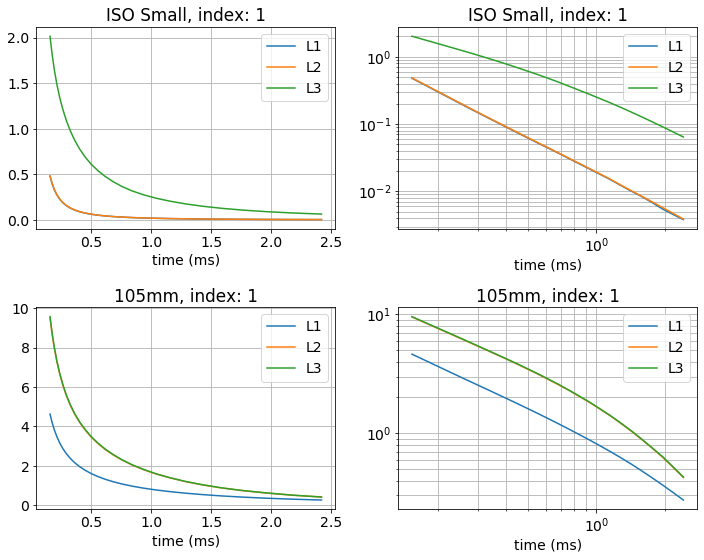

In [11]:
fig, ax = plt.subplots(len(ordnance.keys()), 2, figsize=(10, 4*len(ordnance.keys())))

for i, key in enumerate(ordnance.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
plt.tight_layout()

# ranges of parameters

In [12]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_105mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [13]:
ntrain = 256
ntest = 128
nvalid = 128

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "105mm"
}
n_class = len(class_dict.keys())

In [14]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_105mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return {
        "labels": labels,
        "depths": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    }

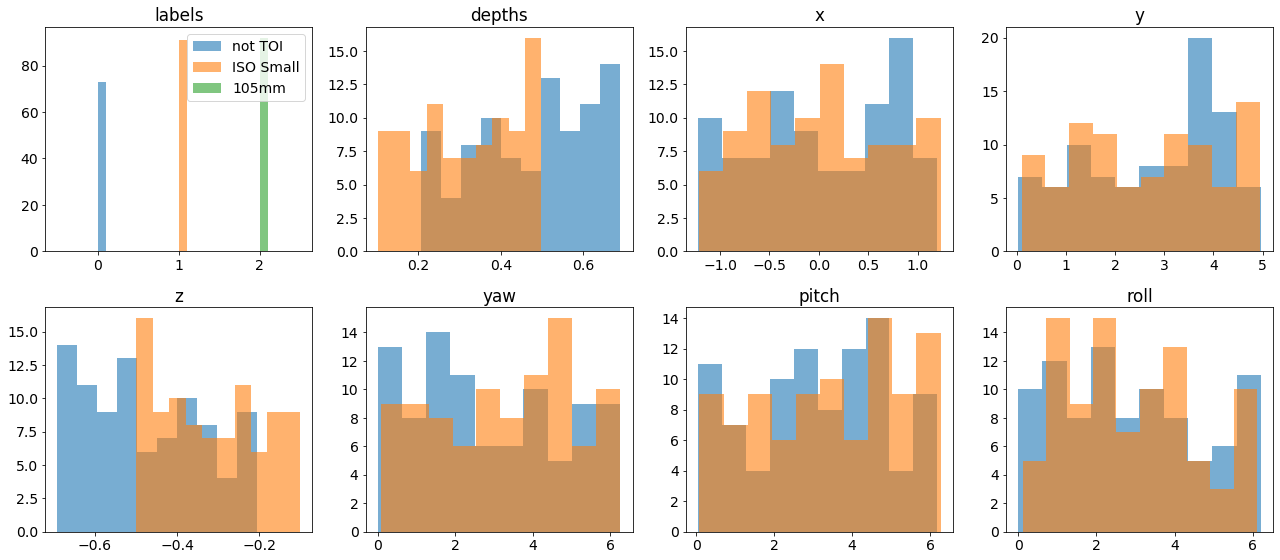

In [15]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "labels" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [16]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [17]:
def run_simulations(parameters):
    data = []
    for i, l in enumerate(parameters["labels"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"]
            L2 = ordnance[class_dict[l]]["L2"]
            L1 = ordnance[class_dict[l]]["L1"]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        data.append(V)
    return data
    
    

In [18]:
%%time
data_train = run_simulations(params_train)

CPU times: user 1.21 s, sys: 171 ms, total: 1.38 s
Wall time: 365 ms


In [19]:
%%time
data_test = run_simulations(params_test)
data_valid = run_simulations(params_valid)

CPU times: user 1.14 s, sys: 166 ms, total: 1.31 s
Wall time: 336 ms


TODOs: 
- plot some data
- set up CNN